# CNN Implementation - Splice Random

## Load Data

In [1]:
# Hyper Parameters
N = 400
SIZE = 5_000
LR = 0.0001
EPOCHS = 30
splits = [0.8, 0.1, 0.1]
SEED = 21
data_dir = "../data/age_decades/"

In [2]:
# Imports
import os
import math
import numpy as np
import pandas as pd
from datetime import datetime
np.random.seed(seed=SEED)

In [3]:
def raw_recording_to_dict(filepath, rawPythonic=True):
    
    recording = {}
    
    with open(filepath) as raw_recording:
        
        recording["Gender"] = filepath.split("/")[-1][0:1]
        recording["AgeDecade"] = filepath.split("/")[-1][1:3]
        recording["RecordingStartTime"] = datetime.strptime(filepath.split("/")[-1][4:9], '%H.%M').time()
        
        series = {"ContractionNo": [], "ContractionNoNorm": [], "RrInterval": []}
        
        first_index = None
        previous_ContractionNo = None
        
        for line in raw_recording:
            
            # Handling shifted indexes
            if first_index is None:
                first_index = int(line.split()[1])
            
            # Fill missing data with None's
            if previous_ContractionNo is not None:
                diff = abs(previous_ContractionNo - int(line.split()[1]))
                
                if diff > 1:
                    
                    filling_indexes = np.array(range(previous_ContractionNo+1, int(line.split()[1])))
                    
                    series["ContractionNo"].extend(filling_indexes)
                    series["ContractionNoNorm"].extend(filling_indexes - first_index)
                    series["RrInterval"].extend([math.nan]*(diff-1))
          
            series["ContractionNo"].append(int(line.split()[1]))
            series["ContractionNoNorm"].append(int(line.split()[1]) - first_index)
            series["RrInterval"].append(int(line.split()[0]))
            
            previous_ContractionNo = int(line.split()[1])
            
        if rawPythonic:
            recording["Series"] = series
            recording["RecordingStartTime"] = str(recording["RecordingStartTime"])
        else:
            recording["Series"] = pd.DataFrame(series)
            
        return recording

In [4]:
def splice_random(series, n=100, size=500, sigma=50):
    cap = len(series) - size
    starts = np.random.randint(cap, size=n)
    ends = [max(min(round(np.random.normal(start+size, sigma)), cap+size), start+1) for start in starts]
    splices = [series.iloc[start:end,] for start, end in zip(starts, ends)]
    return splices

In [5]:
def splice_constant(series, n=48):
    return np.array_split(series, n)

In [6]:
def splice_rr_intervals_constant(rr_intervals, n=48):
    
    spliced_recordings = []
    
    for recording in rr_intervals:
        recording_copy = recording.copy()
        # List of data frames
        splices = splice_constant(recording_copy["Series"], n=n)
        
        for splice in splices:
            #spliced_recording = {}
            recording_copy["Series"] = splice
            spliced_recordings.append(recording_copy)
            
    return spliced_recordings  

In [7]:
def splice_rr_intervals_random(rr_intervals, n=48, size=500, sigma=50):
    
    spliced_recordings = []
    
    for recording in rr_intervals:
        # List of data frames
        splices = splice_random(recording["Series"], n=n, size=500, sigma=50)
        
        for splice in splices:
            recording_copy = recording.copy()
            recording_copy["Series"] = splice
            spliced_recordings.append(recording_copy)
            
    return spliced_recordings  

In [8]:
def decade_to_label(decade):
    return(int(int(decade)/10) - 2)

In [9]:
def label_to_decade(label):
    return(str((label+2)*10))

In [10]:
def pad(l, size, padding):
    l = list(l)
    l = l[0:min(len(l), size)]
    return l + [padding] * abs((len(l)-size))

In [11]:
def normalise(l):
    scaled = l - np.mean(l)
    return scaled / np.std(scaled)

In [12]:
def rr_interval_dict_to_matrix(rr_interval_dict, pad_length):
    data = []
    labels = []
    for recording in rr_interval_dict:
        label = decade_to_label(recording["AgeDecade"])
        
        # Interpolate
        series = recording["Series"]["RrInterval"].interpolate(method='linear', axis=0, limit_direction='both')
        
        # Normalise
        #series = normalise(series)
        
        # Pad
        series = pad(series, pad_length, 0)
        
        #series = pad(normalise(recording["Series"]["RrInterval"]), pad_length, 0)
        labels.append(label)
        data.append(series)
    data = pd.DataFrame(data)
    
    return labels, data

In [13]:
%%time
recordings = []
for filename in os.listdir(data_dir):
    recordings.append(raw_recording_to_dict(data_dir + filename, False))

CPU times: user 11.1 s, sys: 207 ms, total: 11.3 s
Wall time: 11.3 s


In [14]:
%%time
train_orig, val_orig, test_orig = np.array_split(recordings, (np.array(splits)[:-1].cumsum() * len(recordings)).astype(int))
train = splice_rr_intervals_random(train_orig, n=N, size=SIZE)
val = splice_rr_intervals_random(val_orig, n=N, size=SIZE)
test = splice_rr_intervals_random(test_orig, n=N, size=SIZE)

CPU times: user 8.87 s, sys: 67.8 ms, total: 8.94 s
Wall time: 8.93 s


In [15]:
%%time
max_length_rr = max([recording["Series"].shape[0] for recording in train])
colnames = ["label"] + ["rr" + str(i+1) for i in range(max_length_rr)]

CPU times: user 68.5 ms, sys: 7 µs, total: 68.5 ms
Wall time: 67.1 ms


In [16]:
%%time
train_labels, train = rr_interval_dict_to_matrix(train, max_length_rr)
val_labels, val = rr_interval_dict_to_matrix(val, max_length_rr)
test_labels, test = rr_interval_dict_to_matrix(test, max_length_rr)
train

CPU times: user 35.5 s, sys: 920 ms, total: 36.5 s
Wall time: 36.4 s


,0,1,2,3,4,5,6,7,8,9,...,680,681,682,683,684,685,686,687,688,689
0,1240.0,1240.0,1256.0,1216.0,1240.0,1240.0,1240.0,1264.0,1232.0,1208.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1088.0,1096.0,1096.0,1104.0,1080.0,1096.0,1080.0,1064.0,1056.0,1064.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,1048.0,1072.0,1080.0,1072.0,1080.0,1096.0,1088.0,1080.0,1088.0,1080.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,1184.0,1184.0,1152.0,1128.0,1128.0,1112.0,1112.0,1104.0,1088.0,1104.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,1232.0,1248.0,1240.0,1232.0,1240.0,1232.0,1248.0,1264.0,1264.0,1272.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57595,1176.0,960.0,976.0,1272.0,1264.0,1264.0,1152.0,1144.0,1248.0,1240.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
57596,1200.0,1192.0,1136.0,1056.0,1248.0,1256.0,1224.0,1192.0,1184.0,1216.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
57597,656.0,656.0,640.0,640.0,640.0,656.0,680.0,704.0,688.0,680.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
57598,1008.0,1080.0,1096.0,1256.0,1280.0,1208.0,1128.0,1200.0,1232.0,1160.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [17]:
%%time
train.insert(0, "label", train_labels)
train.columns = colnames
train["label"] = train["label"].astype('int32')

val.insert(0, "label", val_labels)
val.columns = colnames
val["label"] = val["label"].astype('int32')

test.insert(0, "label", test_labels)
test.columns = colnames
test["label"] = test["label"].astype('int32')

CPU times: user 20.2 ms, sys: 0 ns, total: 20.2 ms
Wall time: 19.1 ms


To prevent information leakage, we will assume that the max length is given by the training set. If an entry in the test set it longer, we will simply drop the columns for now.

In [18]:
%%time
save_path_train = "{}/preprocessed/train_spliced_random.csv".format("/".join(data_dir.split("/")[:-2]))
save_path_val = "{}/preprocessed/val_spliced_random.csv".format("/".join(data_dir.split("/")[:-2]))
save_path_test = "{}/preprocessed/test_spliced_random.csv".format("/".join(data_dir.split("/")[:-2]))
train.to_csv(save_path_train)
val.to_csv(save_path_val)
test.to_csv(save_path_test)

CPU times: user 46.2 s, sys: 348 ms, total: 46.6 s
Wall time: 46.6 s


## RrIntervalDataset

In [48]:
# Hyper Parameters
N = 400
SIZE = 5_000
LR = 0.00001
EPOCHS = 30
splits = [0.8, 0.1, 0.1]
SEED = 21
data_dir = "../data/age_decades/"

In [49]:
save_path_train = "{}/preprocessed/train_spliced_random.csv".format("/".join(data_dir.split("/")[:-2]))
save_path_val = "{}/preprocessed/val_spliced_random.csv".format("/".join(data_dir.split("/")[:-2]))
save_path_test = "{}/preprocessed/test_spliced_random.csv".format("/".join(data_dir.split("/")[:-2]))

In [50]:
from torch.utils.data import Dataset
import os

class RrIntervalDataset(Dataset):
    def __init__(self, path, header=True):
        
        self.samples = []
        
        with open(path, 'r') as file:
            if header:
                next(file)
            for line in file:
                self.samples.append(list(map(lambda x: float(x), line.split(",")[1:])))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [51]:
%%time
train_data = RrIntervalDataset(save_path_train)
val_data = RrIntervalDataset(save_path_val)
test_data = RrIntervalDataset(save_path_test)

CPU times: user 14 s, sys: 885 ms, total: 14.9 s
Wall time: 14.9 s


## RrIntervalDataLoader

In [52]:
import torch
def __batch2tensor__(batch):
    """
    Takes a batch and transforms it in such a way that it can directly be fed to the network.
    @param batch: List of x and y labels.
    @return: Two tensors, one for x and one for y.
    """
    #print(batch)
    x, y = [None] * len(batch), [None] * len(batch)
    for i, row in enumerate(batch):
        #print(row)
        y[i] = int(row[0])
        x[i] = row[1:]

    return torch.FloatTensor(x), torch.LongTensor(y)

In [53]:
%%time
from torch.utils.data import DataLoader

# Batch size is one patient size!
rrIntervalDataLoaderTrain = DataLoader(train_data, batch_size=N, num_workers=4, collate_fn=__batch2tensor__, shuffle=True)
rrIntervalDataLoaderVal = DataLoader(val_data, batch_size=N, num_workers=4, collate_fn=__batch2tensor__)
rrIntervalDataLoaderTest = DataLoader(test_data, batch_size=N, num_workers=4, collate_fn=__batch2tensor__)

CPU times: user 607 ms, sys: 312 ms, total: 919 ms
Wall time: 914 ms


## Model Playground

Input: $N, C_{in}, L_{in}$

Output: $N, C_{out} , L_{out}$

where $N$ is a batch size, $C$ denotes a number of channels, $L$ is a length of signal sequence.

In [54]:
import torch.nn as nn
# IN: N, C, L
input = torch.randn(2, 16, 50)
input.shape

torch.Size([2, 16, 50])

In [55]:
input

tensor([[[ 0.1324, -0.8841,  1.1306,  ...,  0.2408,  0.4151,  0.1044],
         [ 2.1141, -1.1038, -0.8250,  ...,  0.8967,  0.4706, -0.7862],
         [ 0.7569,  1.0330, -1.7449,  ..., -0.8668,  0.7469,  1.6374],
         ...,
         [-0.7303,  0.7772,  0.4252,  ..., -0.3673, -1.3784, -0.8307],
         [ 0.7161, -0.1185,  0.8779,  ..., -0.3500, -1.2359,  0.7360],
         [ 1.0798, -0.0268, -0.0540,  ...,  0.1969, -0.9584, -0.0877]],

        [[-1.3553,  1.4786, -0.7723,  ..., -1.7872, -0.0689,  0.3796],
         [ 0.7476, -0.3827, -0.5626,  ..., -1.3212, -0.8430,  0.1863],
         [ 1.5717, -0.2668,  1.1828,  ...,  0.3015,  0.8416,  0.4450],
         ...,
         [ 0.4870,  1.8642,  1.9961,  ..., -0.0085,  0.9403, -0.0691],
         [ 0.3264,  0.6175, -0.7317,  ..., -1.6030, -0.0089,  1.1434],
         [ 0.6149, -1.2169,  0.8836,  ...,  0.0544,  0.0701, -0.9843]]])

In [56]:
#in_channels, out_channels, kernel_size
m = nn.Conv1d(16, 33, 3, stride=2)
output = m(input)
output.shape

torch.Size([2, 33, 24])

In [57]:
# target output size of 5
m = nn.AdaptiveMaxPool1d(5)
input = torch.randn(1, 64, 8)
output = m(input)

In [58]:
output.shape

torch.Size([1, 64, 5])

## Model Definition

In [59]:
import torch.nn as nn

class CnnStage(nn.Module):
    def __init__(self, avg_sequence_length=25_000, dropout=0.25, no_classes=7):
        super().__init__()

        # Dropout
        # Maybe for CNN, check literature
        self.dropout = nn.Dropout(p=dropout)
        
        # Convolutions
        #in_channels, out_channels, kernel_size
        self.conv1d1 = nn.Conv1d(1, 64, 3, stride=1)
        self.conv1d2 = nn.Conv1d(64, 64, 3, stride=1)
        
        self.conv1d3 = nn.Conv1d(64, 128, 3, stride=1)
        self.conv1d4 = nn.Conv1d(128, 128, 3, stride=1)
        
        # Forward // Don't how to _not_ hardcode this...
        self.fc1 = nn.Linear(21120, 256)
        self.fc2 = nn.Linear(256, no_classes)
        
        # Activation
        self.relu = nn.ReLU()

        # Pooling
        ## MaxPool
        self.maxpool = nn.AdaptiveMaxPool1d(avg_sequence_length//10)
        ## Average
        self.avgpool = torch.nn.AvgPool1d(3)
        
        # Softmax
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        
        # CNN
        x = x.view(x.shape[0], -1, x.shape[1])
        x = self.conv1d1(x)
        x = self.relu(x)
        x = self.conv1d2(x)
        x = self.maxpool(x)
        x = self.conv1d3(x)
        x = self.relu(x)
        x = self.conv1d4(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        
        # FFN
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        
        return x
    
model = CnnStage(SIZE).cuda()
X, Y = next(iter(rrIntervalDataLoaderTrain))
X

tensor([[1040., 1016., 1000.,  ...,    0.,    0.,    0.],
        [1072., 1064., 1056.,  ...,    0.,    0.,    0.],
        [1272., 1240., 1264.,  ...,    0.,    0.,    0.],
        ...,
        [1072., 1072., 1024.,  ...,    0.,    0.,    0.],
        [ 776.,  792.,  808.,  ...,    0.,    0.,    0.],
        [ 848.,  840.,  848.,  ...,    0.,    0.,    0.]])

In [60]:
model(X.cuda()).shape[0]

400

## Training

In [61]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.NLLLoss()

In [62]:
training_loss_storage = []
training_accuracy_storage = []
validation_loss_storage = []
validation_accuracy_storage = []

for i in range(EPOCHS):
    
    print("Epoch: {}".format(i+1))
    
    training_loss = 0
    training_accuracy = 0
    training_processed_data = 0
    
    for x, y in rrIntervalDataLoaderTrain:
        x = x.cuda()
        y = y.cuda()
        
        # Reset Gradients
        optimizer.zero_grad()

        # Forward, Loss, Backwards, Update
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        
        training_processed_data += x.shape[0]

        # Calculate Metrics
        training_loss += loss.item()
        training_accuracy += torch.sum(torch.exp(output).topk(1)[1].view(-1) == y).item()
    
    else:
        print("Training Loss: {}".format(training_loss/training_processed_data))
        print("Training Accuracy: {}".format(training_accuracy/training_processed_data))
        
        training_loss_storage.append(training_loss/training_processed_data)
        training_accuracy_storage.append(training_accuracy/training_processed_data)
        
        validation_loss = 0
        validation_accuracy = 0
        validation_processed_data = 0

        model.eval()

        with torch.no_grad():
            for x, y in rrIntervalDataLoaderVal:
                x = x.cuda()
                y = y.cuda()

                output_validation = model(x)
                loss_val = criterion(output_validation, y)
                
                validation_processed_data += x.shape[0]
                
                validation_loss += loss_val.item()
                validation_accuracy += torch.sum(
                    torch.exp(output_validation).topk(1, dim=1)[1].view(-1) == y).item()
            else:
                print("Validation Loss: {}".format(validation_loss/validation_processed_data))
                print("Validation Accuracy: {}".format(validation_accuracy/validation_processed_data))
                
                validation_loss_storage.append(validation_loss/validation_processed_data)
                validation_accuracy_storage.append(validation_accuracy/validation_processed_data)
                
                model.train()
                

Epoch: 1
Training Loss: 0.023536852954162493
Training Accuracy: 0.15901041666666665
Validation Loss: 0.00507372635934088
Validation Accuracy: 0.21083333333333334
Epoch: 2
Training Loss: 0.011045484050280519
Training Accuracy: 0.1885763888888889
Validation Loss: 0.005080824022491773
Validation Accuracy: 0.19027777777777777
Epoch: 3
Training Loss: 0.0070668317046430375
Training Accuracy: 0.2048611111111111
Validation Loss: 0.0046555750734276246
Validation Accuracy: 0.24597222222222223
Epoch: 4
Training Loss: 0.005431822327276071
Training Accuracy: 0.2212326388888889
Validation Loss: 0.0046641012363963655
Validation Accuracy: 0.2288888888888889
Epoch: 5
Training Loss: 0.004784853056901031
Training Accuracy: 0.23835069444444446
Validation Loss: 0.004392050819264518
Validation Accuracy: 0.32680555555555557
Epoch: 6
Training Loss: 0.004532063822779391
Training Accuracy: 0.25300347222222225
Validation Loss: 0.004687716033723619
Validation Accuracy: 0.24944444444444444
Epoch: 7
Training Loss: 

True label:

In [63]:
X, Y = next(iter(rrIntervalDataLoaderVal))
res = model(X.cuda()).cpu()

In [64]:
import numpy as np
import matplotlib.pyplot as plt

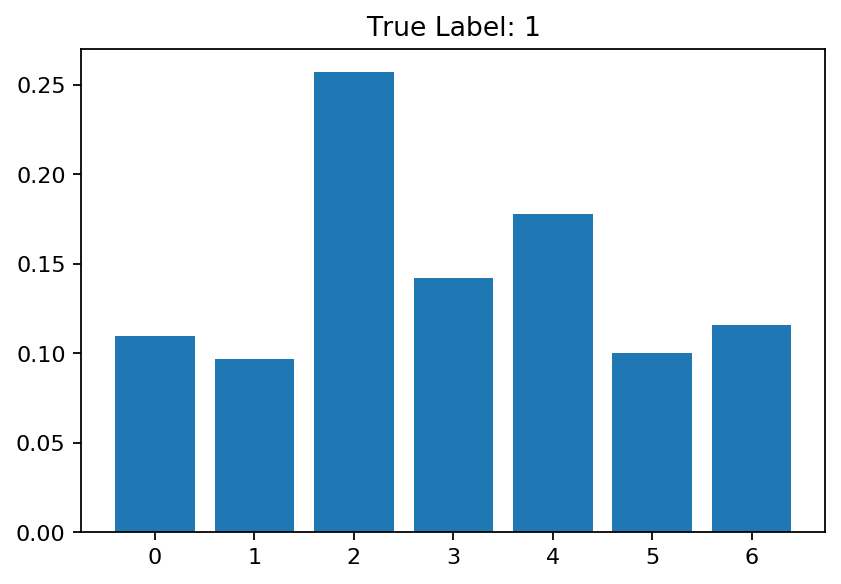

In [65]:
index = 1
true_label = int(Y[1])
posterior = np.array(torch.exp(res[1]).detach().cpu())
plt.bar(range(7), posterior);
plt.title(f'True Label: {true_label}');

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi']= 160

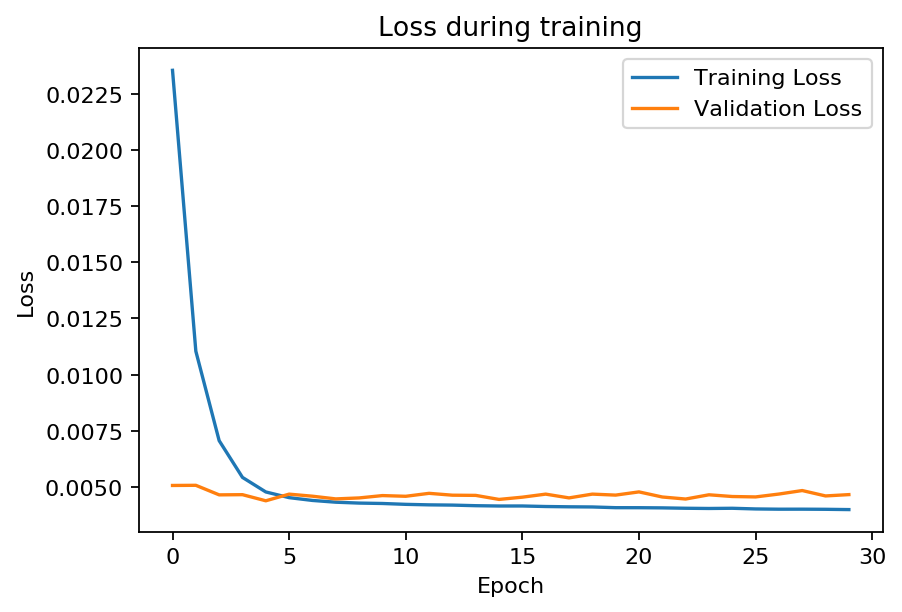

In [67]:
plt.plot(range(len(training_loss_storage)), training_loss_storage, label="Training Loss");
plt.plot(range(len(validation_loss_storage)), validation_loss_storage, label="Validation Loss");
plt.legend()
plt.ylabel('Loss');
plt.xlabel('Epoch');
plt.title('Loss during training');

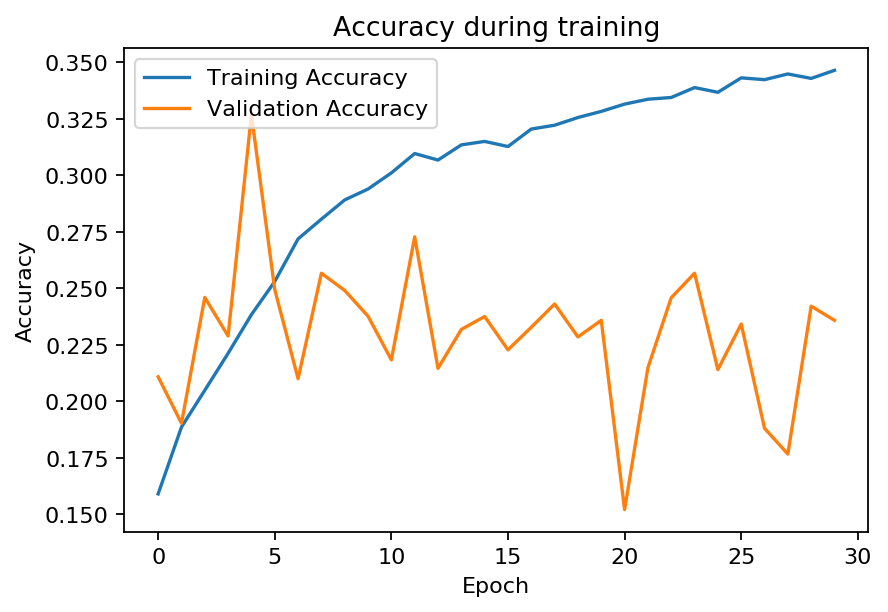

In [68]:
plt.plot(range(len(training_accuracy_storage)), training_accuracy_storage, label="Training Accuracy");
plt.plot(range(len(validation_accuracy_storage)), validation_accuracy_storage, label="Validation Accuracy");
plt.legend()
plt.ylabel('Accuracy');
plt.xlabel('Epoch');
plt.title('Accuracy during training');

## Testing

**This code only works if the data sets are not shuffled!!!**

In [69]:
def distrib(predictions, classes=7):
    res = [0]*classes
    
    for pred in predictions:
        res[pred] += 1
    return res

In [70]:
def classify_with_probs(dataLoader):
    
    matches = []
    model.eval()
    
    for x, y in dataLoader:
        
        y_hat = model(x.cuda()).cpu()
        y_hat = np.array(torch.exp(y_hat).detach().numpy())
        y_hat = np.argmax(np.sum(y_hat, axis=0))
        matches.append(np.argmax(y_hat) == np.array(y[0]))
        
    model.train()
    
    return matches

In [71]:
def classify(dataLoader):
    
    matches = []
    model.eval()
    
    for x, y in dataLoader:

        y_hat = model(x.cuda()).cpu()
        y_hat = distrib(np.array(torch.exp(y_hat).topk(1, dim=1)[1].view(-1)))
        matches.append(np.argmax(y_hat) == y[0])
  
    model.train()
    
    return matches

In [72]:
np.mean(classify(rrIntervalDataLoaderVal))

0.2222222222222222

In [73]:
np.mean(classify_with_probs(rrIntervalDataLoaderVal))

0.16666666666666666

In [74]:
np.mean(classify(rrIntervalDataLoaderTest))

0.2631578947368421

In [75]:
np.mean(classify_with_probs(rrIntervalDataLoaderTest))

0.15789473684210525